## Introduction

It is very hard to quantify what exactly makes a hockey team good - although one common
trait about them is that they are always competing for the Stanley Cup in May and June.
If you ask anyone in the hockey community, there are always a few common characteristics
of these teams such as work ethic, resilience, and toughness. From the perspective of a data
scientist, these traits are hard to quantify since there is no true number to represent these.
However, there are other quantifiable factors that are influenced by these traits - these will
help us determine who will hoist the cup this year.

We look to build a model that can predict these yearly champions, specifically, the Stanley
Cup winners for the modern era of the National Hockey League (NHL). The NHL provides
access to a wide array of data involving players, teams and previous champions for over
the last century. Some categories hypothesized to have large correlations include goals for,
goals against, shots, and scoring depth. We will carefully select a set of features that heavily
influence these teams successfulness.

These tools and resources will allow us to create a supervised learning model that we
will verify by predicting a subset of the previous Stanley Cup winners. The end goal of our
model is to make a prediction for the next champion, which will be determined in June 2025.
Aside from this, we will also produce a set of likelihoods for playoff teams to win the Stanley
Cup.

## Imports

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8,3)

## Data Loading

In [208]:
df = pd.read_csv('NHLTeamPlayoffStats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              376 non-null    int64  
 1   faceoffWinPct           376 non-null    float64
 2   gamesPlayed             376 non-null    int64  
 3   goalsAgainst            376 non-null    int64  
 4   goalsAgainstPerGame     376 non-null    float64
 5   goalsFor                376 non-null    int64  
 6   goalsForPerGame         376 non-null    float64
 7   losses                  376 non-null    int64  
 8   otLosses                0 non-null      float64
 9   penaltyKillNetPct       376 non-null    float64
 10  penaltyKillPct          376 non-null    float64
 11  pointPct                376 non-null    float64
 12  points                  376 non-null    int64  
 13  powerPlayNetPct         376 non-null    float64
 14  powerPlayPct            376 non-null    fl

We will inspect certain years considered as "outliers"

In [209]:
df['seasonId'].unique()

array([20002001, 20012002, 20022003, 20032004, 20052006, 20062007,
       20072008, 20082009, 20092010, 20102011, 20112012, 20122013,
       20132014, 20142015, 20152016, 20162017, 20172018, 20182019,
       20192020, 20202021, 20212022, 20222023, 20232024])

Since this dataset includes every seasons after the 2000-01 season, the important ones to note are:

- **2004-05:** season did not occur due to a lockout
- **2019-20:** season was cut short due to COVID-19
- **2020-21:** season was cut short due to COVID-19

2004-05 is already excluded - we will drop the other two seasons since these are "outlier" seasons.

In [210]:
df = df[df['seasonId'] != 20192020]
df = df[df['seasonId'] != 20202021]
seasons = df['seasonId'].unique()
seasons

array([20002001, 20012002, 20022003, 20032004, 20052006, 20062007,
       20072008, 20082009, 20092010, 20102011, 20112012, 20122013,
       20132014, 20142015, 20152016, 20162017, 20172018, 20182019,
       20212022, 20222023, 20232024])

Some of the features such as `otLosses` and `ties` have null values because there are no ties or overtime losses in playoffs (an overtime loss is just a loss). We don't need these so we will drop them.

We can also drop:
- `winsInShootout`: there are no shootouts in playoffs
- `regulationAndOtWins`: this will be the same as the `wins` feature
- `points`: this is the same as `wins` to a factor in the playoffs
- `pointPct`: see previous point

In [211]:
print(df['regulationAndOtWins'].corr(df['wins']))
print(df['points'].corr(df['wins']))
print(f'shootout wins: {len(df[df["winsInShootout"] != 0])}')

1.0
1.0
shootout wins: 0


In [212]:
# rename id column
df = df.rename(columns={'Unnamed: 0': 'id'});

df = df.drop(['otLosses', 'ties', 'regulationAndOtWins', 'winsInShootout', 'points', 'pointPct'], axis=1)
df.describe()

,id,faceoffWinPct,gamesPlayed,goalsAgainst,goalsAgainstPerGame,goalsFor,goalsForPerGame,losses,penaltyKillNetPct,penaltyKillPct,...,seasonId,shotsAgainstPerGame,shotsForPerGame,teamId,wins,winsInRegulation,playoffScore,last3PlayoffScore,last5PlayoffScore,winRateAgainst500Teams
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,...,3.360000e+02,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,188.300595,0.499654,10.928571,29.255952,2.849904,29.255952,2.516399,5.464286,0.825632,0.806032,...,2.011296e+07,30.560915,30.106001,16.297619,5.464286,4.214286,0.341518,0.628162,0.950335,0.235753
std,108.652763,0.031712,6.288650,14.756328,0.683598,20.443003,0.635243,1.920488,0.085724,0.084341,...,6.778374e+04,3.809628,3.873156,10.740388,4.645515,3.759395,0.290345,0.618098,0.830918,0.077133
min,0.000000,0.400432,4.000000,7.000000,1.500000,2.000000,0.400000,4.000000,0.478260,0.437500,...,2.000200e+07,20.166660,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060976
25%,93.750000,0.479810,6.000000,17.750000,2.387812,13.750000,2.142850,4.000000,0.770432,0.756457,...,2.006201e+07,27.887500,27.500000,7.000000,2.000000,1.000000,0.125000,0.125000,0.187500,0.182927
50%,188.500000,0.498375,7.500000,24.000000,2.700000,22.000000,2.541955,4.000000,0.840289,0.813447,...,2.011201e+07,30.366665,29.742855,16.000000,3.500000,3.000000,0.218750,0.468750,0.812500,0.246951
75%,282.250000,0.520118,14.250000,39.250000,3.258927,41.250000,2.943377,7.000000,0.884615,0.860848,...,2.016202e+07,32.783378,32.510415,23.000000,7.250000,6.000000,0.453125,1.000000,1.500000,0.291667
max,375.000000,0.593023,26.000000,70.000000,5.600000,88.000000,4.333330,12.000000,1.047619,1.000000,...,2.023202e+07,44.000000,44.285710,55.000000,16.000000,15.000000,1.000000,3.000000,3.687500,0.439024


Note that teams that have won the Stanley Cup every season have a `playoffScore` of 1.0. This is calculated by

$$
\text{playoffScore} = \frac{\text{playoff wins}}{\text{number of possible games played}}
$$

In [213]:
df[df['playoffScore'] == 1.0][['teamFullName', 'seasonId']]

,teamFullName,seasonId
3,Colorado Avalanche,20002001
27,Detroit Red Wings,20012002
47,New Jersey Devils,20022003
57,Tampa Bay Lightning,20032004
77,Carolina Hurricanes,20052006
89,Anaheim Ducks,20062007
105,Detroit Red Wings,20072008
121,Pittsburgh Penguins,20082009
135,Chicago Blackhawks,20092010
147,Boston Bruins,20102011


In [214]:
smin = int(str(seasons[0])[:4])
smax = int(str(seasons[-1])[:4])

@ipywidgets.interact(season=(smin,smax))
def disp(season=smin):
    seasonId = int(f'{season}{season+1}')
    print(f'Season: {seasonId}')
    
    df_season = df[df['seasonId'] == seasonId]
    
    plt.scatter(df_season['teamFullName'], df_season['playoffScore'])
    plt.xlabel('team')
    plt.ylabel('playoffScore')
    plt.xticks(rotation=60, ha='right')
    plt.ylim(-0.2,1.2)
    
    return

interactive(children=(IntSlider(value=2000, description='season', max=2023, min=2000), Output()), _dom_classes…

We can also look at teams who have had the most playoff success over the last couple decades.

The expected ones are the teams with dominant eras such as the 2010-2015 Chicago Blackhawks or the Pittsburgh Penguins in the 2010s. We can look at their `last3PlayoffScore` and `last5PlayoffScore` which is the team's total `playoffScore` over the past 3 and 5 years.

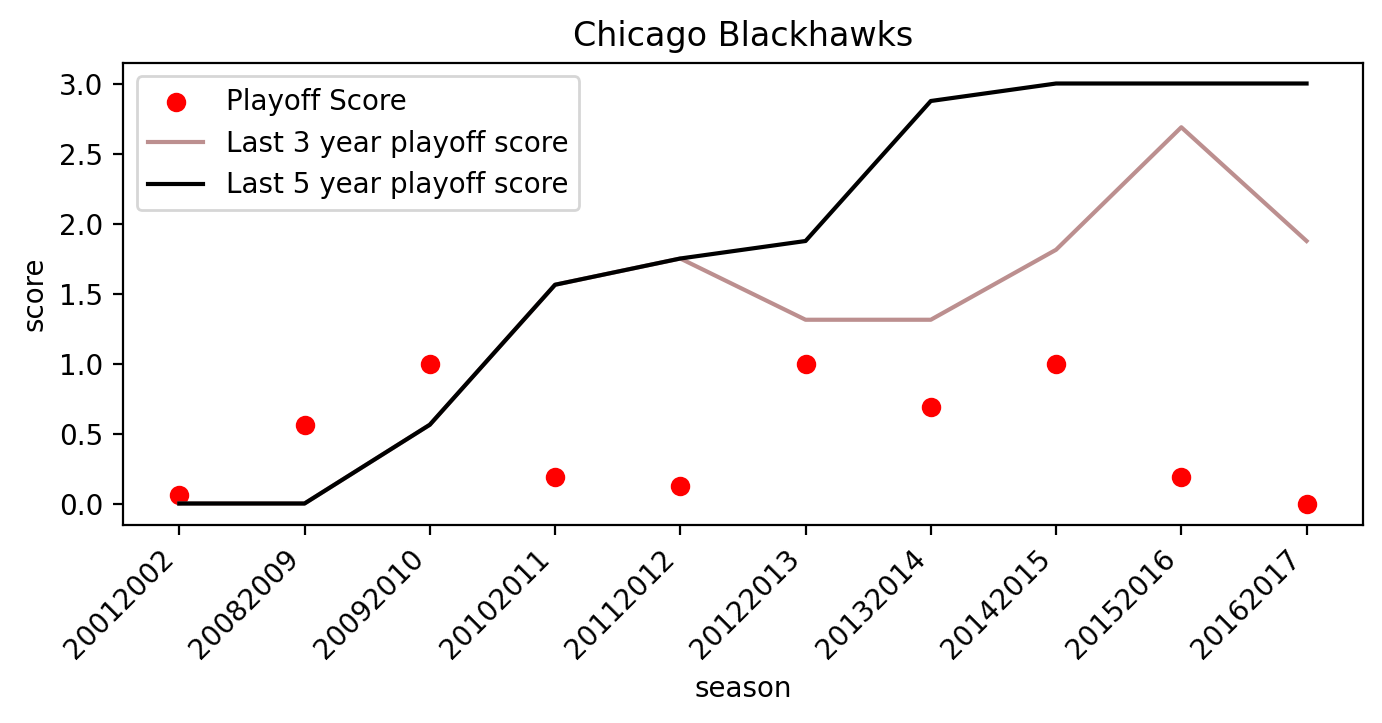

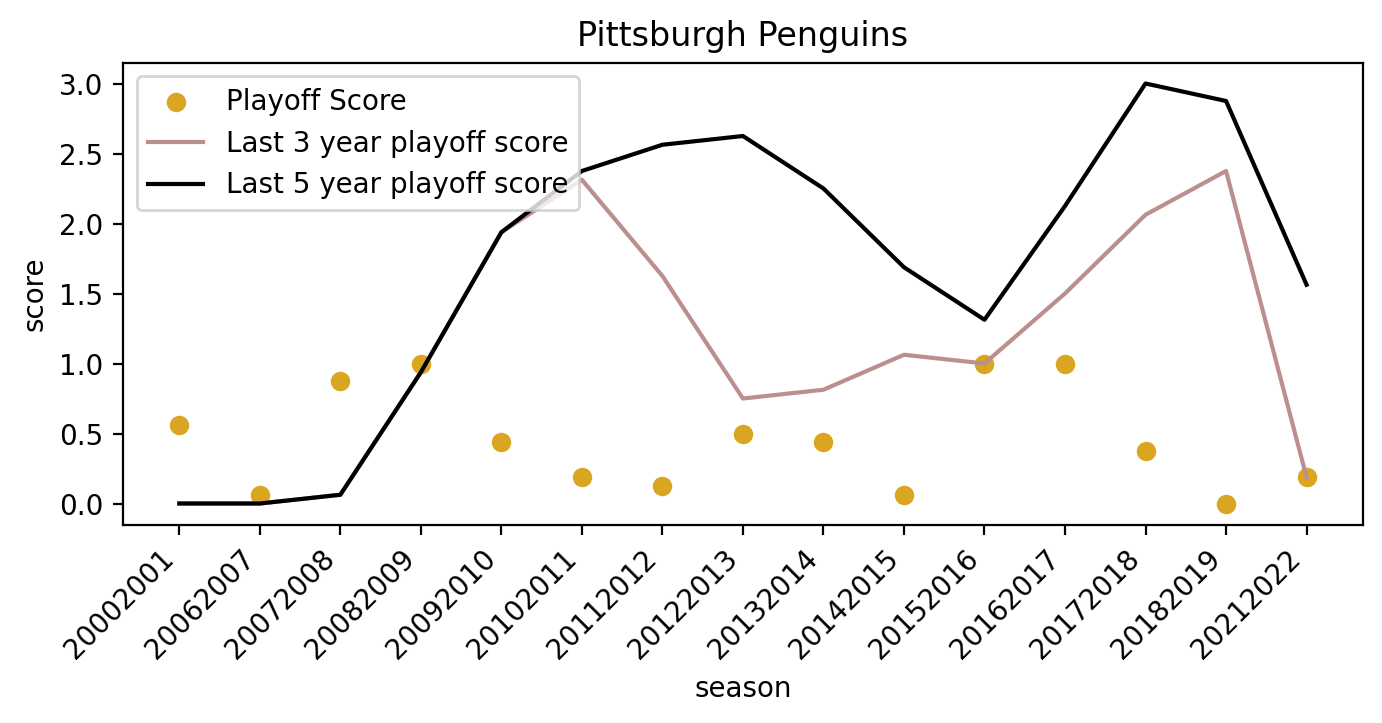

In [215]:
chi_df = df[df['teamFullName'] == 'Chicago Blackhawks']
pit_df = df[df['teamFullName'] == 'Pittsburgh Penguins']
colors = ['red', 'goldenrod']

for t_df, color in zip([chi_df, pit_df],colors):
    plt.figure()
    plt.title(t_df['teamFullName'].iloc[0])
    plt.xlabel('season')
    plt.ylabel('score')
    plt.xticks(rotation=45, ha='right')
    plt.scatter(t_df['seasonId'].astype(str), t_df['playoffScore'], label='Playoff Score', color=color)
    plt.plot(t_df['seasonId'].astype(str), t_df['last3PlayoffScore'], label='Last 3 year playoff score', color='rosybrown')
    plt.plot(t_df['seasonId'].astype(str), t_df['last5PlayoffScore'], label='Last 5 year playoff score', color='black')
    plt.legend();

For completeness we will look at how each feature compares against `playoffScore`.

In [ ]:
# don't include these features
exclude = ['id', 'teamFullName', 'seasonId', 'teamId', 'playoffScore']
keys = [key for key in df.keys() if key not in exclude]

# for grid of plots
plt_cols = 3
plt_rows = int(np.ceil(len(keys) / plt_cols))
fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(12,14))
fig.tight_layout()
ax = ax.flatten()

for i,key in enumerate(keys):
    ax[i].scatter(df[key], df['playoffScore'], s=2)
    ax[i].set(xlabel=key, ylabel='playoffScore' if i % plt_cols == 0 else '')